In [1]:
%%capture
import os
from IPython.display import Javascript

os.environ['R_HOME'] = 'C:/Users/erneilso/Documents/R/R-4.1.1/'
%load_ext rpy2.ipython

%run -i ./MDT_Functions.py


C:\Users\erneilso\OneDrive - NRCan RNCan\Collaborations\RC Steering Committee\MonitoringDecisionTool
The study area has (417996.4415538451, 795945.195356781, 1126884.4543278955, 1581144.825542611). 
It has 76 rows and 91 columns.

------------------
Finished inputing Use vars: ['elevation', 'water_proximity']

------------------
Used the inputted rasters to simulate the spatial probability of use across study area.

------------------
Converting use into occupancy. What is the true proportion of the area that is occupied (number between 0 and 1)?0.5
There are 3458 occupied pixels (86450.0 km occupied area). This leads to an instantaneous probability of detection in any cell for one, randomly moving, individual of 0.0003

------------------
Simulate a population within the occupied cells using a population density. What is the density of individuals per km2 (0.001 - 1)?0.01

With a density of 0.01 individuals per pixel across all occupied pixels, the total population is 864.5. This give

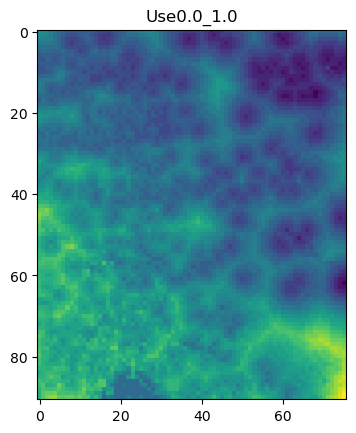

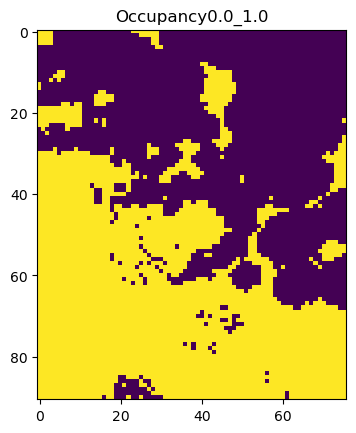

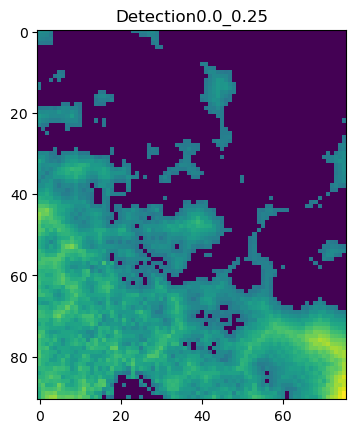

In [2]:
0.01### INPUT DATA
inputSpatial()

# SIMULATE RESPONSE
simulateReponse()

# ## simulate resposne
# Javascript("Jupyter.notebook.execute_cells([2])")

In [3]:
## SIMULATE OCCUANPCY DATA
simulateOccupancyData()

Enter the configuration of cameras 
 (1) Systematic
 (2) Random
 (3) Stratigied Random 
2
------------------
Enter the number of site scenarios.4
Enter the max number of cameras.50
Enter the min number of cameras.10
Enter the number of duration scenarios.10
Enter the max duration of deployments (weeks).12
Enter the min duration of deployments (weeks).2


In [4]:
%R -i cwd
%R -i trueOcc
%R -i popPX
%R -i N
%R -i meanDetection

Javascript("Jupyter.notebook.execute_cells([4])")


<IPython.core.display.Javascript object>

In [8]:
%%R

library(unmarked)
options(warn=2)

getParams = function(modObject){
    
    outParams = list()
    psiTab = predict(modObject, type="state",newdata=data.frame(1))
    outParams$psi = psiTab$Predicted
    outParams$psiSE = psiTab$SE
    outParams$psiBias = outParams$psi - trueOcc
    
    pTab = predict(modObject, type="det",newdata=data.frame(1))
    outParams$p = pTab$Predicted
    outParams$pSE = pTab$SE
    outParams$pBias = outParams$p - meanDetection
    
    return(outParams)
    }


OccOutTab = data.frame(CamN = NA, IntervalsN = NA, Response = NA, Estimate = NA,
                       SE = NA, Bias = NA, inSig = NA)


dhScenDirs = list.dirs(paste0(cwd,'/Data/DetectionHistories'),recursive = FALSE)  
# print(dhScenDirs)
scenCount = 0
FailCount = 0 

for (dir in dhScenDirs){    

    scenI = unlist(strsplit(dir,"/"))
    scen = scenI[length(scenI)]
    scen = unlist(strsplit(scen,"_"))
    CameraNumber = scen[1]
    VisitsNumber = scen[2]

    dhScens = list.files(dir,pattern="\\.csv$")
    
    for (scen in dhScens){        
        dh = read.csv(paste0(dir,"/",scen),header=T)

        ## fit model to scenario data
        umf <- unmarkedFrameOccu(y=as.matrix(dh)) # organize data
        fm <- try(occu(~1 ~1, umf)) # fit a model
        modOut = try(coef(fm)) 
#         print('')
#         print('')
#         print(class(fm))
        
        if(class(modOut) != "try-error" ){    

#             ## model outputs
#             psiTab = predict(fm, type="state",newdata=data.frame(1))
#             psi = psiTab$Predicted
#             psiSE = psiTab$SE
#             psiBias = psi - trueOcc
#             pTab = predict(fm, type="det",newdata=data.frame(1))
#             p = pTab$Predicted
#             pSE = pTab$SE
#             pBias = p - meanDetection
            
            OP = try(getParams(fm))
            if(class(OP)!= "try-error"){

                ## occupancy info
                scenCount = scenCount + 1
                OccOutTab[scenCount,"CamN"] = CameraNumber
                OccOutTab[scenCount,"IntervalsN"] = VisitsNumber
                OccOutTab[scenCount,"Response"] = "psi"
                OccOutTab[scenCount,"Estimate"] = OP$psi
                OccOutTab[scenCount,"SE"] = OP$psiSE
                OccOutTab[scenCount,"Bias"] = OP$psiBias
                OccOutTab[scenCount,"inSig"] = dplyr::between(0,OP$psi-(OP$psiSE*2.58),OP$psi+(OP$psiSE*2.58))

                ## detection info
                scenCount = scenCount + 1
                OccOutTab[scenCount,"CamN"] = CameraNumber
                OccOutTab[scenCount,"IntervalsN"] = VisitsNumber
                OccOutTab[scenCount,"Response"] = "p"
                OccOutTab[scenCount,"Estimate"] = OP$p
                OccOutTab[scenCount,"SE"] = OP$pSE
                OccOutTab[scenCount,"Bias"] = OP$pBias
                OccOutTab[scenCount,"inSig"] = dplyr::between(0,OP$p-(OP$pSE*2.58),OP$p+(OP$pSE*2.58))
            }
            else{
                FailCount = FailCount + 1 
                print("Model failed")
            }
        }
        else{
            FailCount = FailCount + 1 
            print("Model failed")
        }
    }
}



print("Fit occupancy models to all detection histories.")
print(paste0(FailCount," models failed."))

[1] "Fit occupancy models to all detection histories."
[1] "0 models failed."


In [36]:
%%R
options(warn=1)
# print(OccOutTab)
require(tidyverse)

# print(OccOutTab %>% filter(Estimate>0.9999))

SumTab = OccOutTab %>%
    filter(!inSig)%>%
    group_by(CamN, IntervalsN, Response) %>%
    summarise(
        N = length(Estimate),
        
        meanEstimate = mean(Estimate),
        sdEstimate = sd(Estimate),
        seEstimate   = sdEstimate / sqrt(N),
        UpperCI_Est = quantile(Estimate,probs = 0.9),
        LowerCI_Est = quantile(Estimate,probs = 0.1),
        
        meanSE = mean(SE),
        sdSE = sd(SE),
        seSE   = sdSE / sqrt(N),
        UpperCI_SE = quantile(SE,probs = 0.9),
        LowerCI_SE = quantile(SE,probs = 0.1),
        
        meanBias = mean(Bias),
        sdBias = sd(Bias),
        seBias   = sdBias / sqrt(N),
        UpperCI_Bias = quantile(Bias,probs = 0.9),
        LowerCI_Bias = quantile(Bias,probs = 0.1)) %>%

    mutate(CamN = as.factor(CamN),
           Durations = as.numeric(IntervalsN))


print(SumTab)
print(meanDetection)


        
   

`summarise()` has grouped output by 'CamN', 'IntervalsN'. You can override using the `.groups` argument.
# A tibble: 73 x 20
# Groups:   CamN, IntervalsN [39]
   CamN  IntervalsN Response     N meanEstimate sdEstimate seEstimate
   <fct> <chr>      <chr>    <int>        <dbl>      <dbl>      <dbl>
 1 11    10         p            2        0.217   2.19e- 2   1.55e- 2
 2 11    10         psi          2        0.791   2.94e- 1   2.08e- 1
 3 11    11         p            3        0.219   4.12e- 2   2.38e- 2
 4 11    2          p            1        1.00   NA         NA       
 5 11    2          psi          5        0.998   7.41e- 4   3.32e- 4
 6 11    3          psi          8        0.999   2.40e- 4   8.48e- 5
 7 11    4          psi          2        0.998   1.30e-10   9.22e-11
 8 11    5          psi          2        0.998   5.46e-11   3.86e-11
 9 11    6          p            4        0.106   1.45e-12   7.24e-13
10 11    6          psi          7        0.999   2.86e- 4   1.08e- 4
#

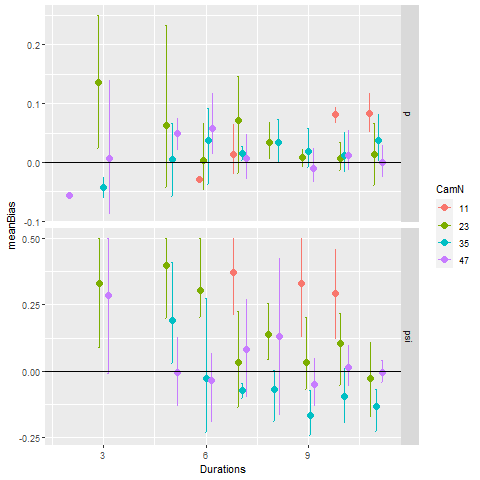

In [39]:
%%R


pd <- position_dodge(0.5)
SumTab %>%
    filter(!is.na(sdEstimate),meanEstimate < 0.99, meanEstimate > 0.001)%>%
    ggplot(
        aes(x=Durations, y=meanBias,ymin=LowerCI_Bias, ymax=UpperCI_Bias, colour=CamN)) + 
        #aes(x=Durations, y=meanEstimate,ymin=UpperCI_Est, ymax=LowerCI_Est, colour=CamN)) +
        geom_errorbar(width=0.1,position = pd)+
        geom_point(size = 3, position = pd) +        
        facet_grid(Response~.,scales="free") +
        geom_abline(size=0.5,intercept = 0, slope=0) 
#         ylim(0,1)+
#         theme(panel.border = element_blank(), panel.grid.major = element_blank(),
#               axis.line = element_line(colour = "black"))
# #         geom_abline(size=0.5,intercept = trueOcc, slope=0)

In [ ]:
%whos